In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.ensemble import RandomForestClassifier
import joblib
from joblib import load
import lime
import lime.lime_tabular
import shap

In [2]:
#pip install nvidia-cuda-toolkit

In [3]:
#I had to downgrade sklearn for joblib to load the dataset correctly

#pip uninstall sklearn --yes
#pip install -v scikit-learn==1.2.2

In [4]:
#loading in trained model
model = joblib.load('model_final.pkl')

In [5]:
#making sure the model loaded correctly
type(model)

sklearn.ensemble._forest.RandomForestClassifier

In [6]:
df = pd.read_csv("cleaned_data.csv")

In [7]:
# take random sample of dataframe to reduce size
df = df.sample(n=2000000, random_state=42)

df = df.drop(columns=['YEAR_OF_DISCHARGE'])

print(df.columns)
print(df.shape)



Index(['AGE', 'GENDER', 'RACE', 'MARITAL_STATUS', 'EDUCATION',
       'EMPLOYMENT_AT_ADMISSION', 'LIVING_ARRANGEMENT_AT_ADMISSION',
       'ARRESTS_IN_30_DAYS_PRIOR_TO_ADMISSION', 'SERVICES_AT_ADMISSION',
       'REASON_FOR_DISCHARGE', 'PRIMARY_SOURCE_OF_REFERRAL',
       'PRIOR_TREATMENT_EPISODES', 'PRIMARY_SUBSTANCE_ABUSE',
       'FREQUENCY_OF_USE', 'AGE_AT_FIRST_USE', 'ALCOHOL_OR_DRUG_ABUSE',
       'DSM_DIAGNOSIS', 'PSYCHIATRIC_PROBLEM', 'HEALTH_INSURANCE',
       'PRIMARY_PAYMENT_METHOD', 'FREQUENCY_OF_SELF_HELP_ATTENDANCE', 'STATE'],
      dtype='object')
(2000000, 22)


In [8]:
#removing/filtering 'transferred to another treatment' option from data
df = df[df['REASON_FOR_DISCHARGE'] != 'Transferred to another treatment program or facility']

In [9]:
# Create target variable. If the patient completed treatment and had no prior treatment episodes,
#they are considered a success. Otherwise, they are considered a failure.

df['SUCCESSFUL_TREATMENT'] = df.apply(lambda row: 1 if row['REASON_FOR_DISCHARGE'] == 'Treatment completed' and row['PRIOR_TREATMENT_EPISODES'] == "No prior treatment episode" else 0, axis=1)

print(df['SUCCESSFUL_TREATMENT'].value_counts())

0    1293487
1     277163
Name: SUCCESSFUL_TREATMENT, dtype: int64


In [10]:
#creating train/test splits
target = df['SUCCESSFUL_TREATMENT']
features = df.drop(['REASON_FOR_DISCHARGE', 'PRIOR_TREATMENT_EPISODES', 'SUCCESSFUL_TREATMENT'], axis=1)
features_one_hot = pd.get_dummies(features)

# LIME for Bias Analysis

In [73]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(features_one_hot),
    feature_names=features_one_hot.columns,
    class_names=['0', '1'],
    training_labels=df['SUCCESSFUL_TREATMENT']
)

# Explain the predictions for a specific instance
i = 10
exp = explainer.explain_instance(features_one_hot.iloc[i], model.predict_proba, num_features=193)
print(exp.as_list())
#exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


[('STATE_South Dakota <= 0.00', 0.11483438318434425), ('PRIMARY_SUBSTANCE_ABUSE_Heroin > 0.00', -0.09289823144747197), ('STATE_Michigan <= 0.00', 0.0722373958165178), ('STATE_North Carolina <= 0.00', 0.07170980489701434), ('STATE_North Dakota <= 0.00', -0.0611929809545058), ('STATE_Georgia <= 0.00', -0.05630114018246065), ('STATE_Hawaii <= 0.00', 0.047688552814234564), ('0.00 < PSYCHIATRIC_PROBLEM_No <= 1.00', 0.04648812647842795), ('STATE_Colorado <= 0.00', -0.04483102877307794), ('STATE_Alabama <= 0.00', 0.03998599200931786), ('ARRESTS_IN_30_DAYS_PRIOR_TO_ADMISSION_Not known <= 0.00', 0.033863207873516835), ('STATE_California <= 0.00', -0.03364684528859837), ('STATE_Iowa <= 0.00', 0.03296179293252697), ('STATE_District of Columbia <= 0.00', 0.02791441729117441), ('PSYCHIATRIC_PROBLEM_Yes <= 0.00', 0.0274376049294325), ('DSM_DIAGNOSIS_Opioid dependence > 0.00', -0.026648383574955675), ('FREQUENCY_OF_SELF_HELP_ATTENDANCE_No attendance <= 0.00', -0.024928030573987785), ('PRIMARY_SOURCE_

In [74]:
#creating list of lime explainer output
exp_list = exp.as_list()

#sorting, rounding, and filtering the list of tuples via the RACE variables
exp_list_rounded = [(item[0],round(item[1],10)) for item in exp_list]
exp_list_sorted = sorted(exp_list_rounded, key=lambda x: x[1])
exp_list_filtered_race = [t for t in exp_list_sorted if t[0].startswith('RACE_')]
exp_list_filtered_race

[('RACE_Native Hawaiian or Other Pacific Islander <= 0.00', -0.0082286483),
 ('RACE_Asian or Pacific Islander <= 0.00', -0.0054114362),
 ('RACE_Two or more races <= 0.00', -0.0048026039),
 ('RACE_Not known <= 0.00', -0.0030582016),
 ('RACE_American Indian <= 0.00', -0.001125605),
 ('RACE_Other single race <= 0.00', 0.0002042464),
 ('RACE_Asian <= 0.00', 0.0011964284),
 ('RACE_Alaskan Native <= 0.00', 0.001947098),
 ('RACE_Black or African American <= 0.00', 0.0020169006)]

# SHAP for Bias Analysis

In [21]:
needed_features = features_one_hot_sample[['RACE_Black or African American','RACE_White','RACE_Other single race', 'RACE_American Indian', 'RACE_Asian or Pacific Islander', 'RACE_Two or more races','RACE_Alaskan Native',
 'RACE_Native Hawaiian or Other Pacific Islander','RACE_Asian','RACE_Not known']]

In [45]:
# Sampling data due to high computational need for SHAP
features_one_hot_sample = features_one_hot.sample(n=500, random_state=42)

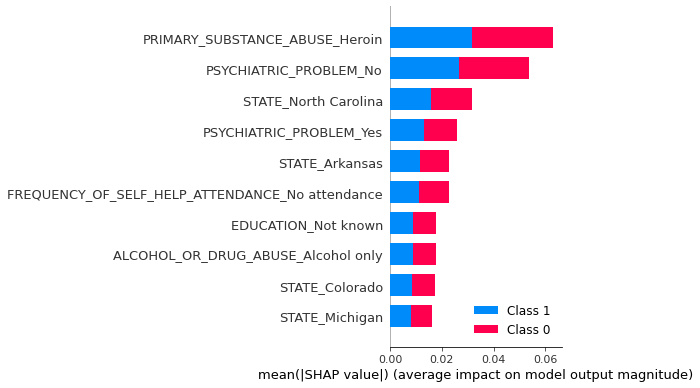

In [51]:
#setting up SHAP for Bias Analysis

# Create an explainer object
explainer =  shap.TreeExplainer(model)

# Creating shap_values
shap_values = explainer.shap_values(features_one_hot_sample)

# Plots the top ten most impactful variables for the model
shap.summary_plot(shap_values, features_one_hot_sample, max_display=10)

# Print the explanation
#print(shap_values)

In [53]:
#mean of values over the random sample of 500
vals= np.abs(shap_values).mean(0)

#creating dataframe of the sum of means, regarding the shap_values means for the RACE_ variables for comparison
feature_importance = pd.DataFrame(list(zip(needed_features.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
1,RACE_White,0.741734
3,RACE_American Indian,0.119614
2,RACE_Other single race,0.102159
0,RACE_Black or African American,0.075214
5,RACE_Two or more races,0.069602
8,RACE_Asian,0.049578
6,RACE_Alaskan Native,0.040047
9,RACE_Not known,0.038218
7,RACE_Native Hawaiian or Other Pacific Islander,0.037945
4,RACE_Asian or Pacific Islander,0.031553


In [62]:
from nltk import flatten
#combining shap_values and feature names into a list of tuples
shap_values_list = flatten(shap_values[1].tolist())
feature_names_list = list(features_one_hot_sample.columns)
combined_shap_list = list(zip(feature_names_list, shap_values_list))

In [63]:
combined_shap_list

[('AGE_12-14', -7.309568292218037e-05),
 ('AGE_15-17', -0.000704679772013125),
 ('AGE_18-20', -0.00013772815719177811),
 ('AGE_21-24', -0.0001197235808739599),
 ('AGE_25-29', 0.00021940451785521704),
 ('AGE_30-34', 9.386476180263631e-05),
 ('AGE_35-39', -1.0666674701650046e-05),
 ('AGE_40-44', -5.368569591136649e-05),
 ('AGE_45-49', 8.97951879510043e-05),
 ('AGE_50-54', 5.550153710683846e-05),
 ('AGE_55-64', -0.00011508573495975968),
 ('AGE_65+', -4.917683258691328e-05),
 ('GENDER_Female', 0.0007063836582323107),
 ('GENDER_Male', 0.0005251663680967229),
 ('GENDER_Not known', -9.851917406445254e-07),
 ('RACE_Alaskan Native', -1.1533719851031381e-05),
 ('RACE_American Indian', 8.807972704355243e-06),
 ('RACE_Asian', -2.5126591485683304e-05),
 ('RACE_Asian or Pacific Islander', -9.069618433885422e-08),
 ('RACE_Black or African American', 0.0005194745297988273),
 ('RACE_Native Hawaiian or Other Pacific Islander', -1.8322393469483115e-05),
 ('RACE_Not known', -0.0002550194487639197),
 ('RAC

In [64]:
#sorting, rounding, and filtering the list of tuples via the RACE variables
combined_shap_list_rounded = [(item[0],round(item[1],10)) for item in combined_shap_list]
combined_shap_list_sorted = sorted(combined_shap_list_rounded, key=lambda x: x[1])
combined_shap_list_filtered_race = [t for t in combined_shap_list_sorted if t[0].startswith('RACE_')]
combined_shap_list_filtered_race

[('RACE_Not known', -0.0002550194),
 ('RACE_Asian', -2.51266e-05),
 ('RACE_Native Hawaiian or Other Pacific Islander', -1.83224e-05),
 ('RACE_Alaskan Native', -1.15337e-05),
 ('RACE_Two or more races', -1.08191e-05),
 ('RACE_Asian or Pacific Islander', -9.07e-08),
 ('RACE_American Indian', 8.808e-06),
 ('RACE_Other single race', 0.0001795103),
 ('RACE_White', 0.0002844438),
 ('RACE_Black or African American', 0.0005194745)]

# source : https://deepchecks.com/reducing-bias-and-ensuring-fairness-in-machine-learning/#

# source : https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability